In [5]:
# angiogenesis_classifier_cv_report.py

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# -------------------------------
# Step 1: Load Dataset
# -------------------------------
data = pd.read_excel("Dataset.xlsx")

target_col = "PRO OR ANTI ANGIOGENIC 1=ANTI 0=PRO"
X = data.drop(columns=[target_col])
y = data[target_col]

# -------------------------------
# Step 2: Identify Feature Types
# -------------------------------
categorical_cols = ["Plant Source", "Target"]
numeric_cols = [col for col in X.columns if col not in categorical_cols and pd.api.types.is_numeric_dtype(X[col])]

# -------------------------------
# Step 3: Preprocessing
# -------------------------------
# Pre-fit encoder to lock categories
ohe = OneHotEncoder(handle_unknown="ignore")
ohe.fit(X[categorical_cols])

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(categories=ohe.categories_, handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# -------------------------------
# Step 4: Define Models
# -------------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "SVM": SVC(probability=True, kernel="rbf", random_state=42),
    "MLP (Neural Net)": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

# -------------------------------
# Step 5: Cross Validation
# -------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    clf = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

    all_y_true, all_y_pred, all_y_prob = [], [], []
    acc_scores, f1_scores, roc_scores = [], [], []

    fold = 1
    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        if hasattr(clf.named_steps["model"], "predict_proba"):
            y_prob = clf.predict_proba(X_test)[:, 1]
        else:
            y_prob = clf.decision_function(X_test)
            y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())

        # store fold metrics
        acc_scores.append(accuracy_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        roc_scores.append(roc_auc_score(y_test, y_prob))

        # collect global preds
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_y_prob.extend(y_prob)

        print(f"[{name}] Fold {fold}: ACC={acc_scores[-1]:.4f}, F1={f1_scores[-1]:.4f}, ROC-AUC={roc_scores[-1]:.4f}")
        fold += 1

    # Convert global results
    all_y_true, all_y_pred, all_y_prob = np.array(all_y_true), np.array(all_y_pred), np.array(all_y_prob)

    # -------------------------------
    # Step 6: Metrics & Report
    # -------------------------------
    print("="*70)
    print(f"Final Results - {name}")
    print(f"Accuracy: {np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}")
    print(f"F1-score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
    print(f"ROC-AUC: {np.mean(roc_scores):.4f} ± {np.std(roc_scores):.4f}")
    print("\nClassification Report (all folds combined):")
    print(classification_report(all_y_true, all_y_pred, target_names=["PRO (0)", "ANTI (1)"]))
    print("\n")


[Logistic Regression] Fold 1: ACC=0.7871, F1=0.7226, ROC-AUC=0.8742
[Logistic Regression] Fold 2: ACC=0.7811, F1=0.7412, ROC-AUC=0.8932
[Logistic Regression] Fold 3: ACC=0.8010, F1=0.7647, ROC-AUC=0.8967
[Logistic Regression] Fold 4: ACC=0.7711, F1=0.7051, ROC-AUC=0.8527
[Logistic Regression] Fold 5: ACC=0.7960, F1=0.7630, ROC-AUC=0.9022
Final Results - Logistic Regression
Accuracy: 0.7873 ± 0.0106
F1-score: 0.7393 ± 0.0231
ROC-AUC: 0.8838 ± 0.0182

Classification Report (all folds combined):
              precision    recall  f1-score   support

     PRO (0)       0.89      0.76      0.82       641
    ANTI (1)       0.66      0.84      0.74       365

    accuracy                           0.79      1006
   macro avg       0.78      0.80      0.78      1006
weighted avg       0.81      0.79      0.79      1006



[Random Forest] Fold 1: ACC=0.7871, F1=0.7226, ROC-AUC=0.8813
[Random Forest] Fold 2: ACC=0.7910, F1=0.7500, ROC-AUC=0.8831
[Random Forest] Fold 3: ACC=0.8159, F1=0.7673, RO

/Users/freshliannes.rosal/anaconda3/envs/Numerical/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:08:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/freshliannes.rosal/anaconda3/envs/Numerical/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:08:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/freshliannes.rosal/anaconda3/envs/Numerical/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:08:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/freshliannes.rosal/anaconda3/envs/Numerical/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:08:50] WARN

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

In [13]:
# hybrid_vs_mlonly_fixed_indexing.py
"""
Fixed hybrid vs ML-only script:
- Fixes IndexError by aligning rule-decisions with test-row positions.
- Robust numeric cleaning, safe predict_proba fallback, OneHotEncoder compatibility,
  imputation, and safe rule overrides.
Save next to Dataset.xlsx and run: python hybrid_vs_mlonly_fixed_indexing.py
"""

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")

# ---------------------------
# Load & clean
# ---------------------------
df = pd.read_excel("Dataset.xlsx")

# Target column name used in your file (change if different)
target_col = "PRO OR ANTI ANGIOGENIC 1=ANTI 0=PRO"
if target_col not in df.columns:
    raise KeyError(f"Target column '{target_col}' not found. Check your header names.")

# Drop non-informative name column if present
if "Phytochemical" in df.columns:
    df = df.drop(columns=["Phytochemical"])

# basic numeric cleaning helper
def clean_numeric_series(s):
    s = s.astype(str).fillna("")
    # replace unicode minus/dashes with ASCII hyphen
    s = s.str.replace(r'[\u2010\u2011\u2012\u2013\u2014\u2212–—−]', '-', regex=True)
    # remove commas and tildes and ± and units
    s = s.str.replace(r'[,\~±\sA-Za-z/%]+', '', regex=True)
    # extract first numeric token
    num = s.str.extract(r'(-?\d+\.?\d*(?:[eE][+-]?\d+)?)', expand=False)
    return pd.to_numeric(num, errors='coerce')

# Try to detect common docking & admet columns
docking_col = None
admet_col = None
for c in df.columns:
    cl = c.lower()
    if docking_col is None and ("dock" in cl or "docking" in cl):
        docking_col = c
    if admet_col is None and "admet" in cl:
        admet_col = c

# If docking_col exists, clean it
if docking_col:
    df[docking_col] = clean_numeric_series(df[docking_col])
else:
    print("Warning: docking column not detected by name. Rules may not run.")

if admet_col:
    # ADMET often is 0/1; convert robustly
    df[admet_col] = pd.to_numeric(df[admet_col].astype(str).str.extract(r'(\d+)', expand=False), errors='coerce')
else:
    print("Warning: ADMET column not detected by name. Rules may not run.")

# Clean all columns that look numeric-ish (except categorical names)
# Identify candidate categorical columns
categorical_candidates = []
for c in df.columns:
    if any(k in c.lower() for k in ["plant", "target", "source"]):
        categorical_candidates.append(c)

# Clean other columns to numeric when possible
for c in df.columns:
    if c == target_col or c in categorical_candidates:
        continue
    # If dtype is object, try to clean numerical content
    if df[c].dtype == object:
        cleaned = clean_numeric_series(df[c])
        # if at least 30% parseable into numeric, replace it
        if cleaned.notna().mean() >= 0.3:
            df[c] = cleaned

# Prepare X, y
X = df.drop(columns=[target_col]).copy()
y = pd.to_numeric(df[target_col], errors="coerce")
if y.isnull().any():
    raise ValueError(f"Target column '{target_col}' contains non-numeric values or NaNs. Convert to 0/1.")

y = y.astype(int)

# define categorical and numeric features for preprocessor
categorical_features = [c for c in categorical_candidates if c in X.columns]
numeric_features = [c for c in X.columns if c not in categorical_features]

# OneHotEncoder compatibility across sklearn versions
try:
    onehot = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    onehot = OneHotEncoder(handle_unknown="ignore", sparse=False)

# Preprocessor with imputation
numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

if categorical_features:
    categorical_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", onehot)
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_pipeline, numeric_features),
            ("cat", categorical_pipeline, categorical_features)
        ],
        remainder="drop"
    )
else:
    preprocessor = ColumnTransformer(
        transformers=[("num", numeric_pipeline, numeric_features)],
        remainder="drop"
    )

# ---------------------------
# Models to evaluate
# ---------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42)
}

# ---------------------------
# Rule-based decision function (uses detected docking_col & admet_col)
# ---------------------------
def rule_based_decision_row(row):
    """
    Return 1 (ANTI), 0 (PRO), or None (undecided).
    Example rules:
      - docking <= -9 & admet == 1 -> ANTI
      - admet == 0 -> PRO
      - else undecided
    """
    dock = None
    admet = None
    if docking_col and docking_col in row.index:
        try:
            dock = float(row[docking_col]) if pd.notnull(row[docking_col]) else None
        except Exception:
            dock = None
    if admet_col and admet_col in row.index:
        try:
            admet = int(row[admet_col]) if pd.notnull(row[admet_col]) else None
        except Exception:
            admet = None

    if dock is None and admet is None:
        return None
    # rule examples (tweak thresholds per domain knowledge)
    if admet is not None and admet == 0:
        return 0
    if dock is not None and admet is not None and dock <= -9.0 and admet == 1:
        return 1
    return None

# vectorized wrapper that returns position-aligned numpy array
def rule_decisions_for_df(df_rows):
    # df_rows is X_test subset (a DataFrame)
    # apply row function and return numpy array aligned to df_rows order
    decisions = df_rows.apply(rule_based_decision_row, axis=1)
    # decisions may contain None; convert to numpy object array
    return decisions.to_numpy(dtype=object)

# ---------------------------
# Evaluation helper
# ---------------------------
def get_probs_from_pipeline(pipeline, X_test):
    # Try predict_proba; if not available, fallback to decision_function scaled to [0,1]
    clf = pipeline.named_steps.get("classifier", pipeline.steps[-1][1])
    if hasattr(clf, "predict_proba"):
        probs = pipeline.predict_proba(X_test)[:, 1]
    else:
        try:
            scores = pipeline.decision_function(X_test)
            # scale to [0,1]
            probs = (scores - scores.min()) / (scores.max() - scores.min()) if len(scores) > 1 else np.zeros_like(scores)
        except Exception:
            probs = np.zeros(len(X_test))
    return probs

# ---------------------------
# Train/test split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ---------------------------
# Run experiments
# ---------------------------
for name, model in models.items():
    print("\n" + "="*70)
    print(f"Evaluating model: {name} (ML-only then Hybrid)")
    print("="*70)

    pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", model)])

    # cross-val accuracy on train set
    try:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_acc = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="accuracy")
        print(f"Cross-val Accuracy (5-fold on train): {cv_acc.mean():.4f} ± {cv_acc.std():.4f}")
    except Exception as e:
        print("Cross-val failed:", e)

    # fit pipeline on train
    pipeline.fit(X_train, y_train)

    # ML-only predictions on test
    ml_preds = pipeline.predict(X_test)
    ml_probs = get_probs_from_pipeline(pipeline, X_test)

    # Print ML-only results
    print("\n--- ML-only ---")
    print(classification_report(y_test, ml_preds, zero_division=0))
    cm = confusion_matrix(y_test, ml_preds)
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    else:
        spec = 0.0
    print("Confusion Matrix:\n", cm)
    print(f"Specificity: {spec:.4f}")
    try:
        print(f"ROC-AUC: {roc_auc_score(y_test, ml_probs):.4f}")
    except Exception:
        print("ROC-AUC: N/A (couldn't compute)")

    # Hybrid predictions: compute rule decisions aligned by position
    rd_array = rule_decisions_for_df(X_test)  # numpy object array len = len(X_test)
    # copy ml outputs to final arrays
    final_preds = ml_preds.copy().astype(int)
    final_probs = ml_probs.copy().astype(float)

    # iterate by position (0..n-1)
    for pos, decision in enumerate(rd_array):
        # decision may be None, np.nan, or numeric 0/1
        if decision is None:
            continue
        # treat nan -> undecided
        if (isinstance(decision, float) and np.isnan(decision)):
            continue
        try:
            dec_int = int(decision)
        except Exception:
            continue
        final_preds[pos] = dec_int
        final_probs[pos] = 1.0 if dec_int == 1 else 0.0

    # Print Hybrid results
    print("\n--- Hybrid (Rule + ML) ---")
    print(classification_report(y_test, final_preds, zero_division=0))
    cm2 = confusion_matrix(y_test, final_preds)
    if cm2.size == 4:
        tn, fp, fn, tp = cm2.ravel()
        spec2 = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    else:
        spec2 = 0.0
    print("Confusion Matrix:\n", cm2)
    print(f"Specificity: {spec2:.4f}")
    try:
        print(f"ROC-AUC: {roc_auc_score(y_test, final_probs):.4f}")
    except Exception:
        print("ROC-AUC: N/A (couldn't compute)")

print("\nDone.")



Evaluating model: Logistic Regression (ML-only then Hybrid)
Cross-val Accuracy (5-fold on train): 0.8557 ± 0.0284

--- ML-only ---
              precision    recall  f1-score   support

           0       0.92      0.84      0.88       129
           1       0.75      0.88      0.81        73

    accuracy                           0.85       202
   macro avg       0.84      0.86      0.84       202
weighted avg       0.86      0.85      0.85       202

Confusion Matrix:
 [[108  21]
 [  9  64]]
Specificity: 0.8372
ROC-AUC: 0.9049

--- Hybrid (Rule + ML) ---
              precision    recall  f1-score   support

           0       0.92      0.84      0.88       129
           1       0.75      0.88      0.81        73

    accuracy                           0.85       202
   macro avg       0.84      0.86      0.84       202
weighted avg       0.86      0.85      0.85       202

Confusion Matrix:
 [[108  21]
 [  9  64]]
Specificity: 0.8372
ROC-AUC: 0.9027

Evaluating model: Random Fore

Sanitized columns (original -> sanitized):
  Plant Source -> PlantSource
  Phytochemical -> Phytochemical
  Target -> Target
  Docking Score (kcal/mol) -> DockingScorekcalmol
  ADMET Highlights 1= ADMET passes 0=ADMET not passes -> ADMETHighlights1ADMETpasses0ADMETnotpasses
  MW (g/mol) -> MWgmol
  LogP -> LogP
  TPSA (Å²) -> TPSA
  HBD -> HBD
  HBA -> HBA
  RotB -> RotB
  Aromatic Rings -> AromaticRings
  MR -> MR
  PRO OR ANTI ANGIOGENIC 1=ANTI 0=PRO -> PROORANTIANGIOGENIC1ANTI0PRO
----------------------------------------------------------------------
Detected target column: PROORANTIANGIOGENIC1ANTI0PRO
Dropping non-informative name column(s): ['Phytochemical']
Detected docking column: DockingScorekcalmol
Detected ADMET column: ADMETHighlights1ADMETpasses0ADMETnotpasses
----------------------------------------------------------------------
Numeric columns detected (examples): ['DockingScorekcalmol', 'ADMETHighlights1ADMETpasses0ADMETnotpasses', 'MWgmol', 'LogP', 'TPSA', 'HBD', 'HBA',

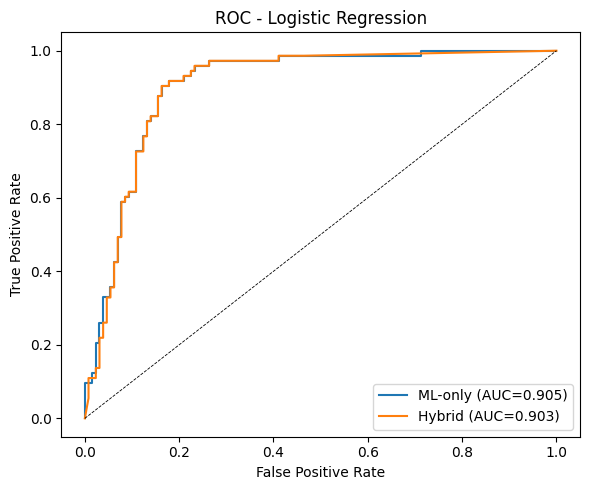


Model: Random Forest
ML-only CV accuracy:   0.9092 ± 0.0300
Hybrid CV accuracy:    0.9030 ± 0.0339
Paired t-test (CV accuracies): t=3.1662, p=0.0340

ML-only on test set:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       129
           1       0.88      0.81      0.84        73

    accuracy                           0.89       202
   macro avg       0.89      0.87      0.88       202
weighted avg       0.89      0.89      0.89       202

Confusion matrix:
 [[121   8]
 [ 14  59]]
Specificity: 0.9380, ROC-AUC: 0.9550

Hybrid (Rule+ML) on test set:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       129
           1       0.87      0.82      0.85        73

    accuracy                           0.89       202
   macro avg       0.89      0.88      0.88       202
weighted avg       0.89      0.89      0.89       202

Confusion matrix:
 [[120   9]
 [ 13  60]]
Specificity: 0.9302, R

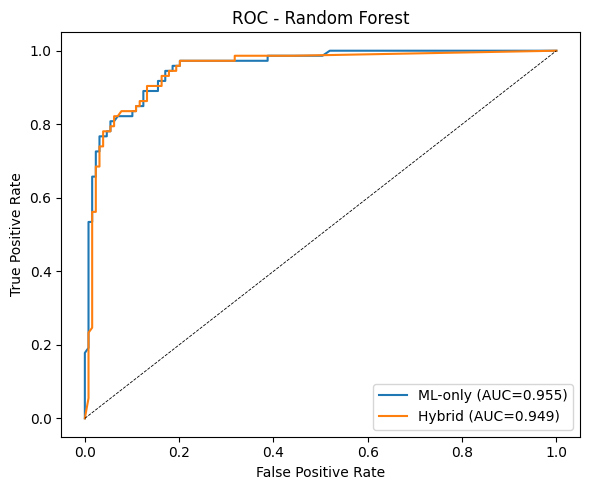


Model: XGBoost
ML-only CV accuracy:   0.9005 ± 0.0244
Hybrid CV accuracy:    0.8943 ± 0.0262
Paired t-test (CV accuracies): t=3.1662, p=0.0340

ML-only on test set:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       129
           1       0.82      0.88      0.85        73

    accuracy                           0.89       202
   macro avg       0.87      0.88      0.88       202
weighted avg       0.89      0.89      0.89       202

Confusion matrix:
 [[115  14]
 [  9  64]]
Specificity: 0.8915, ROC-AUC: 0.9594

Hybrid (Rule+ML) on test set:
              precision    recall  f1-score   support

           0       0.93      0.88      0.91       129
           1       0.81      0.89      0.85        73

    accuracy                           0.89       202
   macro avg       0.87      0.89      0.88       202
weighted avg       0.89      0.89      0.89       202

Confusion matrix:
 [[114  15]
 [  8  65]]
Specificity: 0.8837, ROC-AUC

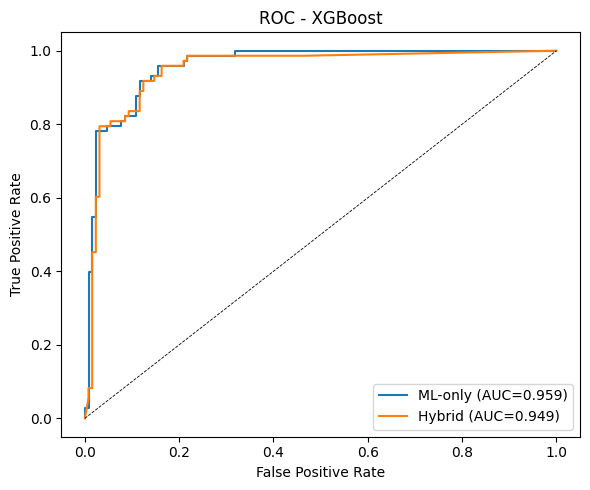


Model: LightGBM
[LightGBM] [Info] Number of positive: 234, number of negative: 409
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 580
[LightGBM] [Info] Number of data points in the train set: 643, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.363919 -> initscore=-0.558394
[LightGBM] [Info] Start training from score -0.558394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

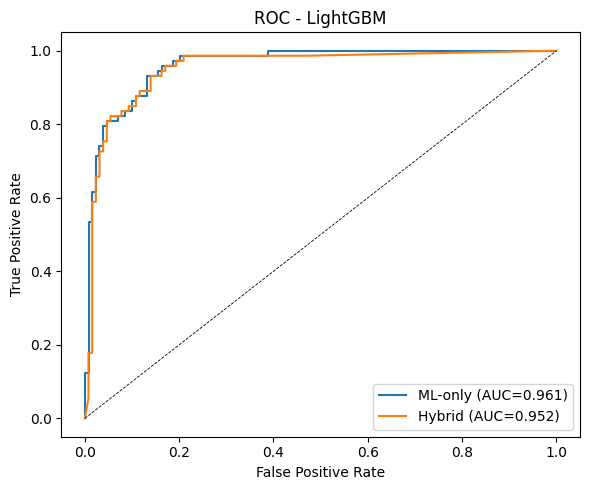


Model: CatBoost
ML-only CV accuracy:   0.9005 ± 0.0214
Hybrid CV accuracy:    0.8943 ± 0.0238
Paired t-test (CV accuracies): t=3.1662, p=0.0340

ML-only on test set:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       129
           1       0.81      0.86      0.83        73

    accuracy                           0.88       202
   macro avg       0.86      0.87      0.87       202
weighted avg       0.88      0.88      0.88       202

Confusion matrix:
 [[114  15]
 [ 10  63]]
Specificity: 0.8837, ROC-AUC: 0.9571

Hybrid (Rule+ML) on test set:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       129
           1       0.81      0.86      0.83        73

    accuracy                           0.88       202
   macro avg       0.86      0.87      0.87       202
weighted avg       0.88      0.88      0.88       202

Confusion matrix:
 [[114  15]
 [ 10  63]]
Specificity: 0.8837, ROC-AU

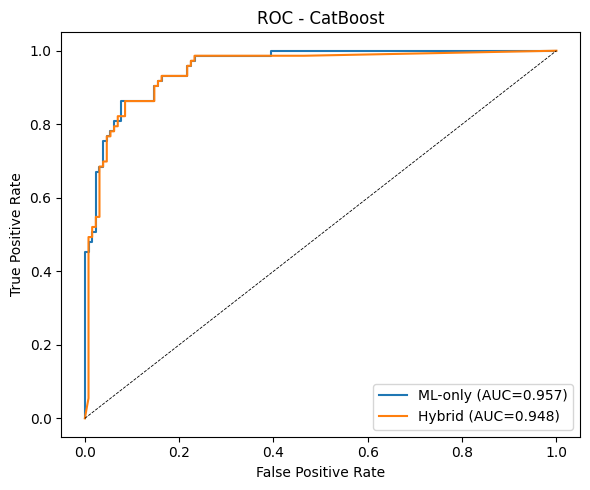


Model: SVM
ML-only CV accuracy:   0.8806 ± 0.0281
Hybrid CV accuracy:    0.8744 ± 0.0312
Paired t-test (CV accuracies): t=3.1662, p=0.0340

ML-only on test set:
              precision    recall  f1-score   support

           0       0.92      0.81      0.86       129
           1       0.73      0.88      0.80        73

    accuracy                           0.84       202
   macro avg       0.82      0.85      0.83       202
weighted avg       0.85      0.84      0.84       202

Confusion matrix:
 [[105  24]
 [  9  64]]
Specificity: 0.8140, ROC-AUC: 0.9333

Hybrid (Rule+ML) on test set:
              precision    recall  f1-score   support

           0       0.92      0.81      0.86       129
           1       0.73      0.88      0.80        73

    accuracy                           0.84       202
   macro avg       0.82      0.85      0.83       202
weighted avg       0.85      0.84      0.84       202

Confusion matrix:
 [[105  24]
 [  9  64]]
Specificity: 0.8140, ROC-AUC: 0.

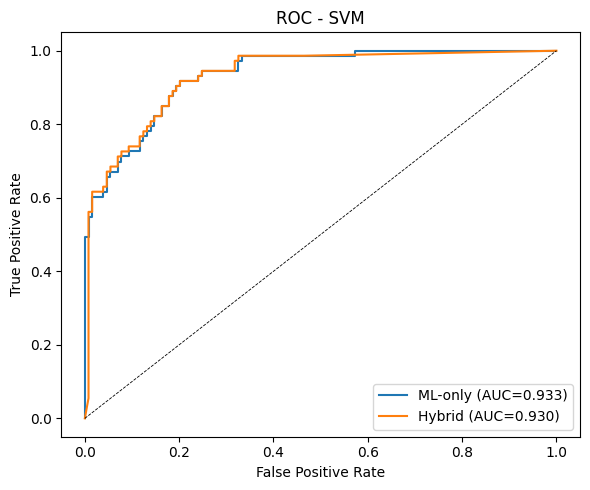


Model: MLP
ML-only CV accuracy:   0.8706 ± 0.0279
Hybrid CV accuracy:    0.8644 ± 0.0318
Paired t-test (CV accuracies): t=3.1662, p=0.0340

ML-only on test set:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       129
           1       0.77      0.75      0.76        73

    accuracy                           0.83       202
   macro avg       0.82      0.81      0.82       202
weighted avg       0.83      0.83      0.83       202

Confusion matrix:
 [[113  16]
 [ 18  55]]
Specificity: 0.8760, ROC-AUC: 0.9244

Hybrid (Rule+ML) on test set:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       129
           1       0.77      0.75      0.76        73

    accuracy                           0.83       202
   macro avg       0.82      0.81      0.82       202
weighted avg       0.83      0.83      0.83       202

Confusion matrix:
 [[113  16]
 [ 18  55]]
Specificity: 0.8760, ROC-AUC: 0.

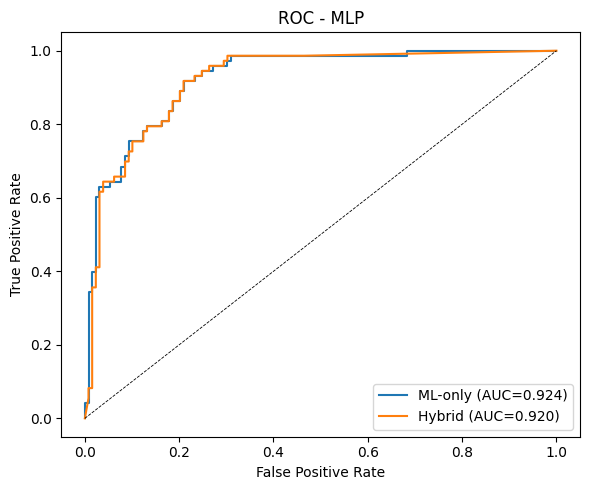


Summary saved to model_comparison_summary.csv

All done.


In [20]:
# hybrid_vs_ml_comparison_full.py
"""
Robust Hybrid (Rule-based + ML) vs ML-only comparison script.
- Cleans column names & numeric values
- Detects target column (looks for 'angiogen' keyword if exact name differs)
- Runs multiple ML models (skips optional libraries if not installed)
- Computes per-model:
    * CV accuracies (ML-only and Hybrid) -> paired t-test
    * Test-set metrics (classification report, specificity, ROC-AUC)
    * McNemar's test on test-set predictions
    * ROC curves (ML-only vs Hybrid)
"""
import re
import sys
import math
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from scipy.stats import ttest_rel
from statsmodels.stats.contingency_tables import mcnemar

warnings.filterwarnings("ignore")

# -------------------------
# Helper functions
# -------------------------
def sanitize_colname(s):
    return re.sub(r'[^A-Za-z0-9_]+', '', str(s).strip())

def clean_numeric_series(s: pd.Series) -> pd.Series:
    """Robustly extract numeric values from a pandas Series (strings -> floats)."""
    s = s.astype(str).fillna("")
    s = s.str.replace(r'[\u2010\u2011\u2012\u2013\u2014\u2212–—−]', '-', regex=True)  # many dash/minus chars -> '-'
    s = s.str.replace(r'[,\~±]', '', regex=True)   # remove commas, tildes, ±
    num = s.str.extract(r'(-?\d+\.?\d*(?:[eE][+-]?\d+)?)', expand=False)
    return pd.to_numeric(num, errors='coerce')

def make_onehot(categories=None):
    """Compatible instantiation of OneHotEncoder across sklearn versions."""
    try:
        if categories is None:
            return OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        else:
            return OneHotEncoder(categories=categories, handle_unknown='ignore', sparse_output=False)
    except TypeError:
        # older sklearn
        if categories is None:
            return OneHotEncoder(handle_unknown='ignore', sparse=False)
        else:
            return OneHotEncoder(categories=categories, handle_unknown='ignore', sparse=False)

def get_probs_from_pipeline(pipe: Pipeline, X):
    clf = pipe.named_steps.get('classifier', pipe.steps[-1][1])
    if hasattr(clf, 'predict_proba'):
        try:
            return pipe.predict_proba(X)[:, 1]
        except Exception:
            pass
    if hasattr(clf, 'decision_function'):
        scores = pipe.decision_function(X)
        # scale to [0,1] safely
        if np.ptp(scores) == 0:
            return np.zeros_like(scores, dtype=float)
        scaled = (scores - scores.min()) / (scores.max() - scores.min())
        return scaled
    # fallback
    return np.zeros(len(X), dtype=float)

# -------------------------
# Load dataset & sanitize column names
# -------------------------
df = pd.read_excel("Dataset.xlsx")
orig_cols = list(df.columns)
col_map = {c: sanitize_colname(c) for c in orig_cols}
df = df.rename(columns=col_map)

print("Sanitized columns (original -> sanitized):")
for o, s in col_map.items():
    print(f"  {o} -> {s}")
print("-"*70)

# -------------------------
# Detect target column (try cleaned exact then keyword search)
# -------------------------
expected_clean = sanitize_colname("PRO OR ANTI ANGIOGENIC 1=ANTI 0=PRO")
target_col = expected_clean if expected_clean in df.columns else None
if target_col is None:
    # search for any column name containing 'angiogen'
    for c in df.columns:
        if 'angiogen' in c.lower():
            target_col = c
            break

if target_col is None:
    raise KeyError("Target column (PRO/ANTI) not found. Make sure your sheet has a header mentioning 'angiogen' or the exact text 'PRO OR ANTI ANGIOGENIC 1=ANTI 0=PRO'.")

print("Detected target column:", target_col)

# -------------------------
# Drop phytochemical name column if present
# -------------------------
phyt_candidates = [c for c in df.columns if any(k in c.lower() for k in ['phytochem','compound','name'])]
if phyt_candidates:
    print("Dropping non-informative name column(s):", phyt_candidates)
    df = df.drop(columns=phyt_candidates)

# -------------------------
# Detect docking and admet columns (sanitized)
# -------------------------
docking_col = None
admet_col = None
for c in df.columns:
    cl = c.lower()
    if docking_col is None and ('dock' in cl or 'docking' in cl or 'score' in cl):
        docking_col = c
    if admet_col is None and 'admet' in cl:
        admet_col = c

print("Detected docking column:", docking_col)
print("Detected ADMET column:", admet_col)
print("-"*70)

# -------------------------
# Clean numeric-like columns
# -------------------------
# Determine categorical candidate columns by name/content
categorical_candidates = []
for c in df.columns:
    if any(k in c.lower() for k in ['plant', 'source', 'target', 'protein']):
        categorical_candidates.append(c)

# Replace numeric-like columns when >=30% parseable
numeric_cols = []
for c in df.columns:
    if c == target_col or c in categorical_candidates:
        continue
    # attempt to parse numeric tokens
    cleaned = clean_numeric_series(df[c])
    if cleaned.notna().mean() >= 0.3:
        df[c] = cleaned
        numeric_cols.append(c)

print("Numeric columns detected (examples):", numeric_cols[:20])
print("Categorical candidates:", categorical_candidates)
print("-"*70)

# If docking or admet were detected and not cleaned yet, coerce them
if docking_col and docking_col not in numeric_cols:
    df[docking_col] = clean_numeric_series(df[docking_col])
    if df[docking_col].notna().mean() >= 0.01:  # at least some numeric
        if docking_col not in numeric_cols:
            numeric_cols.append(docking_col)
if admet_col and admet_col not in numeric_cols:
    df[admet_col] = pd.to_numeric(df[admet_col].astype(str).str.extract(r'(\d+)', expand=False), errors='coerce')
    if df[admet_col].notna().mean() >= 0.01:
        if admet_col not in numeric_cols:
            numeric_cols.append(admet_col)

# Prepare X and y
X = df.drop(columns=[target_col]).copy()
y = pd.to_numeric(df[target_col], errors='coerce')
if y.isnull().any():
    raise ValueError(f"Target column '{target_col}' contains missing/non-numeric values. Convert to 0/1 integers.")
y = y.astype(int)

# Determine final categorical features (those in categorical_candidates present in X)
categorical_features = [c for c in categorical_candidates if c in X.columns]
# Additionally, any remaining non-numeric columns are categorical
for c in X.columns:
    if c not in numeric_cols and c not in categorical_features:
        # treat object dtype as categorical
        if X[c].dtype == object:
            categorical_features.append(c)

# Remove duplicates
categorical_features = list(dict.fromkeys(categorical_features))
# Final numeric features: those in numeric_cols that remain in X
numeric_features = [c for c in numeric_cols if c in X.columns]

print("Final numeric features (examples):", numeric_features[:20])
print("Final categorical features:", categorical_features)
print("-"*70)

# -------------------------
# Pre-fit OneHotEncoder categories (so CV dims stable)
# -------------------------
if categorical_features:
    tmp_ohe = make_onehot()
    tmp_ohe.fit(X[categorical_features].fillna('Missing'))
    categories = tmp_ohe.categories_
else:
    categories = []

# Preprocessing pipelines
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

if categorical_features:
    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', make_onehot(categories=categories))
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_pipeline, numeric_features),
            ('cat', categorical_pipeline, categorical_features)
        ],
        remainder='drop'
    )
else:
    preprocessor = ColumnTransformer(
        transformers=[('num', numeric_pipeline, numeric_features)],
        remainder='drop'
    )

# -------------------------
# Models to evaluate (optional libs handled gracefully)
# -------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    # optional below; will be added only if import succeeds
}

# Try add XGBoost/LightGBM/CatBoost
try:
    from xgboost import XGBClassifier
    models["XGBoost"] = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
except Exception:
    print("XGBoost not available — skipping it.")

try:
    from lightgbm import LGBMClassifier
    models["LightGBM"] = LGBMClassifier(random_state=42)
except Exception:
    print("LightGBM not available — skipping it.")

try:
    from catboost import CatBoostClassifier
    models["CatBoost"] = CatBoostClassifier(verbose=0, random_state=42)
except Exception:
    print("CatBoost not available — skipping it.")

# Add SVM & MLP
models["SVM"] = SVC(probability=True, gamma='scale', random_state=42)
models["MLP"] = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=500, random_state=42)

# -------------------------
# Rule-based decision function (row-based)
# -------------------------
def rule_based_decision_row(row):
    """
    Return:
      - 1 (ANTI) if rule decides anti
      - 0 (PRO) if rule decides pro
      - None if undecided -> ML will decide
    Example rules (edit thresholds to match domain knowledge):
      - If ADMET column exists and equals 0 -> PRO
      - If docking exists and <= -9.0 and ADMET==1 -> ANTI
    """
    dock = None
    admet = None
    if docking_col and docking_col in row.index:
        try:
            dock = float(row[docking_col]) if pd.notnull(row[docking_col]) else None
        except Exception:
            dock = None
    if admet_col and admet_col in row.index:
        try:
            admet = int(row[admet_col]) if pd.notnull(row[admet_col]) else None
        except Exception:
            admet = None

    # Example simple rules
    if admet is not None and admet == 0:
        return 0
    if dock is not None and admet is not None and dock <= -9.0 and admet == 1:
        return 1
    return None

def rule_decisions_for_df(df_rows):
    """Return numpy object array of decisions aligned with df_rows order."""
    decs = df_rows.apply(rule_based_decision_row, axis=1)
    # convert Series to numpy object array retaining None/np.nan
    return decs.to_numpy(dtype=object)

# -------------------------
# Train/test split
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# helper: compute hybrid CV accuracies manually
def hybrid_cv_accuracies(pipeline: Pipeline, X_in: pd.DataFrame, y_in: pd.Series, n_splits=5):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accs = []
    for train_idx, test_idx in cv.split(X_in, y_in):
        Xt, Xv = X_in.iloc[train_idx], X_in.iloc[test_idx]
        yt, yv = y_in.iloc[train_idx], y_in.iloc[test_idx]
        pipeline.fit(Xt, yt)
        preds = pipeline.predict(Xv)
        probs = get_probs_from_pipeline(pipeline, Xv)
        rd = rule_decisions_for_df(Xv)
        # apply rule overrides (by position)
        for pos, decision in enumerate(rd):
            if decision is None:
                continue
            if isinstance(decision, float) and np.isnan(decision):
                continue
            try:
                d = int(decision)
            except Exception:
                continue
            if d not in (0,1):
                continue
            preds[pos] = d
        accs.append(accuracy_score(yv, preds))
    return np.array(accs)

# -------------------------
# Main evaluation loop
# -------------------------
results_summary = []

for name, model in models.items():
    print("\n" + "="*80)
    print(f"Model: {name}")
    print("="*80)

    pipeline = Pipeline([('preprocessor', preprocessor), ('classifier', model)])

    # ML-only CV (accuracy)
    try:
        ml_cv = cross_val_score(pipeline, X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy')
    except Exception as e:
        print("Cross-val (ML-only) failed:", e)
        ml_cv = np.array([np.nan]*5)

    # Hybrid CV (manual)
    try:
        hybrid_cv = hybrid_cv_accuracies(pipeline, X_train, y_train, n_splits=5)
    except Exception as e:
        print("Hybrid CV failed:", e)
        hybrid_cv = np.array([np.nan]*5)

    print(f"ML-only CV accuracy:   {np.nanmean(ml_cv):.4f} ± {np.nanstd(ml_cv):.4f}")
    print(f"Hybrid CV accuracy:    {np.nanmean(hybrid_cv):.4f} ± {np.nanstd(hybrid_cv):.4f}")

    # paired t-test on CV acc (only if enough non-nan pairs)
    mask = ~np.isnan(ml_cv) & ~np.isnan(hybrid_cv)
    if mask.sum() >= 2:
        t_stat, p_val = ttest_rel(ml_cv[mask], hybrid_cv[mask])
        print(f"Paired t-test (CV accuracies): t={t_stat:.4f}, p={p_val:.4f}")
    else:
        print("Paired t-test skipped (insufficient valid CV folds).")

    # Fit on full training set and evaluate on test set
    pipeline.fit(X_train, y_train)
    ml_preds_test = pipeline.predict(X_test)
    ml_probs_test = get_probs_from_pipeline(pipeline, X_test)

    # Hybrid test preds
    rd_test = rule_decisions_for_df(X_test)  # numpy object array
    # copy arrays
    final_preds = ml_preds_test.copy()
    final_probs = ml_probs_test.copy().astype(float)

    for pos, decision in enumerate(rd_test):
        if decision is None:
            continue
        if isinstance(decision, float) and np.isnan(decision):
            continue
        try:
            dec_int = int(decision)
        except Exception:
            continue
        if dec_int not in (0,1):
            continue
        final_preds[pos] = dec_int
        final_probs[pos] = 1.0 if dec_int == 1 else 0.0

    # Print ML-only test set report
    print("\nML-only on test set:")
    print(classification_report(y_test, ml_preds_test, zero_division=0))
    cm = confusion_matrix(y_test, ml_preds_test)
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    else:
        specificity = 0.0
    print("Confusion matrix:\n", cm)
    try:
        roc_ml = roc_auc_score(y_test, ml_probs_test)
    except Exception:
        roc_ml = float('nan')
    print(f"Specificity: {specificity:.4f}, ROC-AUC: {roc_ml:.4f}")

    # Print Hybrid test set report
    print("\nHybrid (Rule+ML) on test set:")
    print(classification_report(y_test, final_preds, zero_division=0))
    cm2 = confusion_matrix(y_test, final_preds)
    if cm2.size == 4:
        tn2, fp2, fn2, tp2 = cm2.ravel()
        specificity2 = tn2 / (tn2 + fp2) if (tn2 + fp2) > 0 else 0.0
    else:
        specificity2 = 0.0
    try:
        roc_h = roc_auc_score(y_test, final_probs)
    except Exception:
        roc_h = float('nan')
    print("Confusion matrix:\n", cm2)
    print(f"Specificity: {specificity2:.4f}, ROC-AUC: {roc_h:.4f}")

    # McNemar's test on test-set predictions (contingency of correctness)
    ml_correct = (ml_preds_test == y_test.to_numpy())
    hy_correct = (final_preds == y_test.to_numpy())
    both_correct = np.sum((ml_correct) & (hy_correct))
    both_wrong = np.sum((~ml_correct) & (~hy_correct))
    b = np.sum((ml_correct) & (~hy_correct))  # ML correct, Hybrid wrong
    c = np.sum((~ml_correct) & (hy_correct))  # ML wrong, Hybrid correct
    cont_table = [[both_correct, b], [c, both_wrong]]
    try:
        mres = mcnemar(cont_table, exact=True)
        print(f"\nMcNemar test (exact): statistic={mres.statistic}, p-value={mres.pvalue:.4f}")
    except Exception as e:
        print("McNemar test failed:", e)
        print("Contingency table:", cont_table)

    # Paired t-test on CV accuracies already printed earlier.

    # ROC curves plotting (safe)
    try:
        fpr_ml, tpr_ml, _ = roc_curve(y_test, ml_probs_test)
        fpr_h, tpr_h, _ = roc_curve(y_test, final_probs)
        plt.figure(figsize=(6,5))
        plt.plot(fpr_ml, tpr_ml, label=f"ML-only (AUC={roc_ml:.3f})")
        plt.plot(fpr_h, tpr_h, label=f"Hybrid (AUC={roc_h:.3f})")
        plt.plot([0,1],[0,1],'k--', linewidth=0.6)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC - {name}")
        plt.legend(loc='lower right')
        plt.tight_layout()
        # save to file
        fname = f"roc_{name.replace(' ', '_')}.png"
        plt.savefig(fname, dpi=200)
        print(f"ROC plot saved to {fname}")
        plt.show()
    except Exception as e:
        print("ROC plotting failed:", e)

    # summarize for CSV or further use
    results_summary.append({
        'model': name,
        'ml_cv_mean': float(np.nanmean(ml_cv)),
        'ml_cv_std': float(np.nanstd(ml_cv)),
        'hybrid_cv_mean': float(np.nanmean(hybrid_cv)),
        'hybrid_cv_std': float(np.nanstd(hybrid_cv)),
        'test_accuracy_ml': float(accuracy_score(y_test, ml_preds_test)),
        'test_accuracy_hybrid': float(accuracy_score(y_test, final_preds)),
        'roc_ml': float(roc_ml) if not math.isnan(roc_ml) else None,
        'roc_h': float(roc_h) if not math.isnan(roc_h) else None,
        'mcnemar_b': int(b), 'mcnemar_c': int(c)
    })

# Optionally save summary CSV
summary_df = pd.DataFrame(results_summary)
summary_df.to_csv("model_comparison_summary.csv", index=False)
print("\nSummary saved to model_comparison_summary.csv")
print("\nAll done.")
